In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch import optim
from torch.autograd import Variable
import numpy as np
import os
import math
from torch import nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn import preprocessing
import itertools
import random
import torch.nn.functional as F
from exploit_pred import *
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
class TorchDataset(Dataset):
    def __init__(self, trs_file, label_file, plaintext_file, trace_num, trace_offset, trace_length):
        self.trs_file = trs_file
        self.label_file = label_file
        self.plaintext_file = plaintext_file
        self.trace_num = trace_num
        self.trace_offset = trace_offset
        self.trace_length = trace_length
        self.ToTensor = transforms.ToTensor()
    def __getitem__(self, i):
        index = i % self.trace_num
        trace = self.trs_file[index,:]
        label = self.label_file[index]
        plaintext = self.plaintext_file[index]
        trace = trace[self.trace_offset:self.trace_offset+self.trace_length]
        trace = np.reshape(trace,(1,-1))
        trace = self.ToTensor(trace)
        trace = np.reshape(trace, (1,-1))
        label = torch.tensor(label, dtype=torch.long) 
        return trace.float(), label, plaintext
    def __len__(self):
        return self.trace_num
    
### data loader for training
def load_training(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

### data loader for testing
def load_testing(batch_size, kwargs):
    data = TorchDataset(**kwargs)
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=True)
    return test_loader

In [3]:
Sbox = [
    99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118,
    202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192,
    183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4,
    199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44,
    26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32,
    252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77,
    51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245,
    188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196,
    167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238,
    184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98,
    145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234,
    101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75,
    189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193,
    29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40,
    223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22
]

def CA_train(epoch, model):
    """
    Train the model for one epoch using cross-attention training.
    
    Parameters:
    - epoch: current epoch number.
    - model: the neural network model to be trained.
    """
    model.train()
    iter_source = iter(source_train_loader)
    iter_target = iter(target_train_loader)
    num_iter_target = len(target_train_loader)
    
    # Pre-load target domain data for efficiency
    train_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    train_pt_all = torch.zeros((num_iter_target, batch_size))
    for i in range(num_iter_target):
        train_trace_all[i, :, :, :], _, train_pt_all[i, :] = iter_target.next()
    
    num_iter = len(source_train_loader)
    clf_criterion = nn.CrossEntropyLoss()
    
    for i in range(1, num_iter + 1):
        source_data, source_label, source_pt = iter_source.next()
        target_data = train_trace_all[(i - 1) % num_iter_target, :, :, :]
        target_pt = train_pt_all[(i - 1) % num_iter_target, :]
        
        if cuda:
            source_data, source_label, source_pt = source_data.cuda(), source_label.cuda(), source_pt.cuda()
            target_data, target_pt = target_data.cuda(), target_pt.cuda()

        source_data = Variable(source_data)
        source_label = Variable(source_label)
        source_pt = Variable(source_pt)
        target_data = Variable(target_data)
        target_pt = Variable(target_pt)

        optimizer.zero_grad()
        source_preds, _, mmd_loss = model(source_data, target_data, source_pt, target_pt)
        preds = source_preds.data.max(1, keepdim=True)[1]
        clf_loss = clf_criterion(source_preds, source_label, 256, epsilon=0.1)
        loss = clf_loss + lambda_ * mmd_loss
        loss.backward()
        optimizer.step()

        if i % log_interval == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\t'
                  'total_loss: {:.6f}\tclf_loss: {:.6f}\t'
                  'mmd_loss: {:.6f}'.format(
                      epoch, i * len(source_data),
                      len(source_train_loader) * batch_size,
                      100. * i / len(source_train_loader),
                      loss.data, clf_loss.data, mmd_loss.data))


def CA_validation(model):
    """
    Validate the model on the source validation dataset and report losses and accuracy.
    
    Parameters:
    - model: the neural network model to be evaluated.
    
    Returns:
    - total_loss: average total loss over the validation set.
    - total_mmd_loss: average MMD loss over the validation set.
    """
    clf_criterion = nn.CrossEntropyLoss()
    model.eval()
    iter_source = iter(source_valid_loader)
    iter_target = iter(target_train_loader)
    
    num_iter_target = len(target_train_loader)
    train_trace_all = torch.zeros((num_iter_target, batch_size, 1, trace_length))
    train_pt_all = torch.zeros((num_iter_target, batch_size))
    for i in range(num_iter_target):
        train_trace_all[i, :, :, :], _, train_pt_all[i, :] = iter_target.next()
    
    num_iter = len(source_valid_loader)
    total_clf_loss = 0
    total_mmd_loss = 0
    total_loss = 0
    correct = 0

    for i in range(1, num_iter + 1):
        source_data, source_label, source_pt = iter_source.next()
        target_data = train_trace_all[(i - 1) % num_iter_target, :, :, :]
        target_pt = train_pt_all[(i - 1) % num_iter_target, :]
        
        if cuda:
            source_data, source_label, source_pt = source_data.cuda(), source_label.cuda(), source_pt.cuda()
            target_data, target_pt = target_data.cuda(), target_pt.cuda()
        
        source_data = Variable(source_data)
        source_label = Variable(source_label)
        source_pt = Variable(source_pt)
        target_data = Variable(target_data)
        target_pt = Variable(target_pt)
        
        valid_preds, _, mmd_loss = model(source_data, target_data, source_pt, target_pt)
        clf_loss = clf_criterion(valid_preds, source_label)
        loss = clf_loss + lambda_ * mmd_loss
        
        total_clf_loss += clf_loss
        total_mmd_loss += mmd_loss
        total_loss += loss
        
        pred = valid_preds.data.max(1)[1]
        correct += pred.eq(source_label.data.view_as(pred)).cpu().sum()
    
    total_loss /= len(source_valid_loader)
    total_clf_loss /= len(source_valid_loader)
    total_mmd_loss /= len(source_valid_loader)
    
    print('Validation: total_loss: {:.4f}, clf_loss: {:.4f}, mmd_loss: {:.4f}, accuracy: {}/{} ({:.2f}%)'.format(
        total_loss.data, total_clf_loss, total_mmd_loss,
        correct, len(source_valid_loader.dataset),
        100. * correct / len(source_valid_loader.dataset)))
    
    return total_loss, total_mmd_loss


def test_rank(model, device_id, disp_GE=True, model_flag='pretrained'):
    """
    Evaluate the performance of the CA_Net model on the source or target domain.
    Regardless of the evaluation domain, predictions are made using the source domain branch (result_source).

    Parameters:
    - model: The CA_Net model
    - device_id: source_device_id or target_device_id
    - disp_GE: Whether to display the GE (Guessing Entropy) curve
    - model_flag: Prefix for naming the GE plot file
    """

    model.eval()
    clf_criterion = nn.CrossEntropyLoss()
    device = next(model.parameters()).device  # 自动获取模型所在设备

    # 加载 source/target 测试集与真实 key
    test_loader_s = source_test_loader
    test_loader_t = target_test_loader
    real_key_s = real_key_01
    real_key_t = real_key_02

    # 判断当前要评估的是哪一个域的数据
    is_source = (device_id == source_device_id)
    total_samples = source_test_num if is_source else target_test_num
    real_key = real_key_s if is_source else real_key_t

    predlist = torch.zeros(0, dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0, dtype=torch.long, device='cpu')
    test_preds_all = torch.zeros((total_samples, class_num), dtype=torch.float, device='cpu')

    epoch = 0
    test_loss = 0
    correct = 0

    # 联合遍历 source 和 target 数据
    for (source_data, source_label, source_pt), (target_data, target_label, target_pt) in zip(test_loader_s, test_loader_t):
        # 移动到相同设备
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        source_pt = source_pt.to(device)
        target_data = target_data.to(device)
        target_label = target_label.to(device)
        target_pt = target_pt.to(device)

        # 如果评估 source，就按原逻辑；评估 target，就让 target 数据走 source 分支
        if is_source:
            input_data = source_data
            input_label = source_label
            input_pt = source_pt
            ref_data = target_data
            ref_pt = target_pt
        else:
            input_data = target_data
            input_label = target_label
            input_pt = target_pt
            ref_data = source_data
            ref_pt = source_pt

        # 推理（始终使用 source 分支）
        with torch.no_grad():
            result_source, _, _ = model(input_data, ref_data, input_pt, ref_pt)

        loss = clf_criterion(result_source, input_label)
        test_loss += loss

        pred = result_source.argmax(dim=1)
        correct += pred.eq(input_label).sum().item()

        # 保存预测与标签
        predlist = torch.cat([predlist, pred.cpu()])
        lbllist = torch.cat([lbllist, input_label.cpu()])
        test_preds_all[epoch * batch_size:epoch * batch_size + pred.size(0), :] = F.softmax(result_source, dim=1).cpu()

        epoch += 1

    test_loss /= len(test_loader_s)
    acc = 100. * correct / total_samples

    domain_name = 'Source' if is_source else 'Target'
    print(f'[{domain_name}] Prediction using SOURCE branch → Loss: {test_loss:.4f}, Accuracy: {correct}/{total_samples} ({acc:.2f}%)')

    # 混淆矩阵
    confusion_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
    plot_sonfusion_matrix(confusion_mat, classes=range(class_num))

    # GE 曲线
    if disp_GE:
        plot_guessing_entropy(test_preds_all.numpy(), real_key, device_id, model_flag + f'_{domain_name.lower()}_via_source')



def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the Gaussian kernel matrix between source and target data.
    
    Parameters:
    - source: source data tensor.
    - target: target data tensor.
    - kernel_mul: multiplicative step for bandwidth.
    - kernel_num: number of Gaussian kernels.
    - fix_sigma: fixed bandwidth value (if provided).
    
    Returns:
    - Sum of the Gaussian kernel matrices.
    """
    n_samples = int(source.size(0)) + int(target.size(0))
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(total.size(0), total.size(0), total.size(1))
    total1 = total.unsqueeze(1).expand(total.size(0), total.size(0), total.size(1))
    
    L2_distance = ((total0 - total1) ** 2).sum(2)
    
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples ** 2 - n_samples)
    
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)


def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Compute the Maximum Mean Discrepancy (MMD) loss using an RBF kernel.
    
    Parameters:
    - source: source data tensor.
    - target: target data tensor.
    - kernel_mul: multiplicative factor for kernel bandwidth.
    - kernel_num: number of kernels.
    - fix_sigma: fixed sigma value.
    
    Returns:
    - MMD loss value.
    """
    batch_size = int(source.size(0))
    kernels = guassian_kernel(source, target, kernel_mul=kernel_mul,
                              kernel_num=kernel_num, fix_sigma=fix_sigma)
    
    XX = kernels[:batch_size, :batch_size]  
    YY = kernels[batch_size:, batch_size:]  
    XY = kernels[:batch_size, batch_size:]  
    YX = kernels[batch_size:, :batch_size] 
    
    loss = torch.mean(XX + YY - XY - YX)
    return loss


def plot_guessing_entropy(preds, real_key, device_id, model_flag):
    """
    Plot guessing entropy based on model predictions.
    
    Parameters:
    - preds: softmax predictions from the model.
    - real_key: the actual cryptographic key.
    - device_id: identifier for the tested device.
    - model_flag: a string for naming GE result.
    """
    model_name = "CA"
    nb_traces_attacks = 1000
    nb_attacks = 200

    if device_id == target_device_id:
        plaintext = plaintexts_target[target_train_num:target_train_num + target_test_num]
        ct = ct_target[target_train_num:target_train_num + target_test_num]
        id_num = target_device_id
    elif device_id == source_device_id:
        plaintext = plaintexts_source
        ct = ct_source
        id_num = source_device_id

    plt_attack_1 = np.array([plaintext for _ in range(16)]).T
    ct_attack_1 = np.array([ct for _ in range(16)]).T
    key_1 = np.array([real_key for _ in range(16)])

    avg_rank = perform_attacks(nb_traces_attacks, predictions=preds, nb_attacks=nb_attacks,
                               plt=plt_attack_1, ct=ct_attack_1, key=key_1, byte=0,
                               filename=model_name, id_num=id_num)
    
    plt.show()



def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix.
    
    Parameters:
    - cm: confusion matrix.
    - classes: list of class labels.
    - normalize: if True, normalize the confusion matrix.
    - title: title for the plot.
    - cmap: color map.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 2.0
    plt.xticks([i for i in range(len(classes)) if i % 20 == 0],
               [classes[i] for i in range(len(classes)) if i % 20 == 0], rotation=45)
    plt.yticks([i for i in range(len(classes)) if i % 20 == 0],
               [classes[i] for i in range(len(classes)) if i % 20 == 0])
    
    plt.ylim((len(classes) - 0.5, -0.5))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [4]:
# Device and cryptographic key settings
source_device_id = 1
target_device_id = 2
real_key_01 = 0x3e
real_key_02 = 0x5f

# Training hyperparameters
lambda_ = 0.02
labeling_method = 'identity' 
preprocess = 'horizontal_standardization' 
batch_size = 100
train_epoch = 50 
lr = 0.001 
log_interval = 40 

# Data splits and trace settings
train_num = 20000
valid_num = 5000
source_test_num = 5000
target_train_num = 500
target_test_num = 5000
trace_offset = 0
trace_length = 500

# File paths for source and target datasets
source_file_path = './Dataset/01_Last_round_ECB_3E/'
target_file_path = './Dataset/02_Last_round_CBC_5F/'

# CUDA settings
no_cuda = False
cuda = not no_cuda and torch.cuda.is_available()
seed = 8
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

# Determine number of classes based on labeling method
if labeling_method == 'identity':
    class_num = 256
elif labeling_method == 'hw':
    class_num = 9

# Load training and attack data for the source
X_train_source = np.load(source_file_path + 'X_train.npy')
Y_train_source = np.load(source_file_path + 'Y_train.npy')
X_attack_source = np.load(source_file_path + 'X_attack.npy')
Y_attack_source = np.load(source_file_path + 'Y_attack.npy')

# Load attack data for the target
X_attack_target = np.load(target_file_path + 'X_attack.npy')
Y_attack_target = np.load(target_file_path + 'Y_attack.npy')

# Load plaintexts and ciphertexts for source and target
plaintexts_source_train = np.load(source_file_path + 'plaintexts_train.npy')
plaintexts_source = np.load(source_file_path + 'plaintexts_attack.npy')
plaintexts_target = np.load(target_file_path + 'plaintexts_attack.npy')
ct_source_train = np.load(source_file_path + 'ct_train.npy')
ct_source = np.load(source_file_path + 'ct_attack.npy')
ct_target = np.load(target_file_path + 'ct_attack.npy')

# Preprocess the traces based on the specified method
if preprocess == 'horizontal_standardization':
    # Standardize source training data
    mn = np.repeat(np.mean(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    std = np.repeat(np.std(X_train_source, axis=1, keepdims=True), X_train_source.shape[1], axis=1)
    X_train_source = (X_train_source - mn) / std

    # Standardize source attack data
    mn = np.repeat(np.mean(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_source, axis=1, keepdims=True), X_attack_source.shape[1], axis=1)
    X_attack_source = (X_attack_source - mn) / std

    # Standardize target attack data
    mn = np.repeat(np.mean(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    std = np.repeat(np.std(X_attack_target, axis=1, keepdims=True), X_attack_target.shape[1], axis=1)
    X_attack_target = (X_attack_target - mn) / std  

elif preprocess == 'horizontal_scaling':
    # Scale data to range [-1, 1] using MinMaxScaler for source training data
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train_source.T)
    X_train_source = scaler.transform(X_train_source.T).T

    # Scale source attack data
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_source.T)
    X_attack_source = scaler.transform(X_attack_source.T).T

    # Scale target attack data
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_attack_target.T)
    X_attack_target = scaler.transform(X_attack_target.T).T

# Configure parameters for data loaders
kwargs_source_train = {
    'trs_file': X_train_source[0:train_num, :],
    'label_file': Y_train_source[0:train_num],
    'plaintext_file': plaintexts_source_train[0:train_num],
    'trace_num': train_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_source_valid = {
    'trs_file': X_train_source[train_num:train_num + valid_num, :],
    'label_file': Y_train_source[train_num:train_num + valid_num],
    'plaintext_file': plaintexts_source_train[train_num:train_num + valid_num],
    'trace_num': valid_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_source_test = {
    'trs_file': X_attack_source,
    'label_file': Y_attack_source,
    'plaintext_file': plaintexts_source,
    'trace_num': source_test_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_target_train = {
    'trs_file': X_attack_target[0:target_train_num, :],
    'label_file': Y_attack_target[0:target_train_num],
    'plaintext_file': plaintexts_target[0:target_train_num],
    'trace_num': target_train_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

kwargs_target = {
    'trs_file': X_attack_target[target_train_num:target_train_num + target_test_num, :],
    'label_file': Y_attack_target[target_train_num:target_train_num + target_test_num],
    'plaintext_file': plaintexts_target[target_train_num:target_train_num + target_test_num],
    'trace_num': target_test_num,
    'trace_offset': trace_offset,
    'trace_length': trace_length,
}

# Initialize data loaders
source_train_loader = load_training(batch_size, kwargs_source_train)
source_valid_loader = load_training(batch_size, kwargs_source_valid)
source_test_loader = load_testing(batch_size, kwargs_source_test)
target_train_loader = load_training(batch_size, kwargs_target_train)
target_test_loader = load_testing(batch_size, kwargs_target)

print('Load data complete!')

Load data complete!


# Attention Layer

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, channel_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert channel_size % num_heads == 0, "channel_size must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = channel_size // num_heads

        self.query_convs = nn.ModuleList(
            [nn.Conv1d(channel_size, self.head_dim, kernel_size=1) for _ in range(num_heads)]
        )
        self.key_convs = nn.ModuleList(
            [nn.Conv1d(channel_size, self.head_dim, kernel_size=1) for _ in range(num_heads)]
        )
        self.value_convs = nn.ModuleList(
            [nn.Conv1d(channel_size, self.head_dim, kernel_size=1) for _ in range(num_heads)]
        )
        self.fc_out = nn.Conv1d(channel_size, channel_size, kernel_size=1)

    def forward(self, x_source, x_target):
        batch_size, c, seq_len = x_source.shape

        query_list = [conv(x_source) for conv in self.query_convs]
        key_list = [conv(x_target) for conv in self.key_convs]
        value_list = [conv(x_target) for conv in self.value_convs]

        attention_heads = []
        for i in range(self.num_heads):
            Q = query_list[i]      # (B, D, T)
            K = key_list[i]
            V = value_list[i]

            scores = torch.matmul(Q.transpose(1, 2), K) / (self.head_dim ** 0.5)
            attention = F.softmax(scores, dim=-1)
            head_output = torch.matmul(attention, V.transpose(1, 2)).transpose(1, 2)
            attention_heads.append(head_output)

        out = torch.cat(attention_heads, dim=1)  # (B, C, T)
        out = self.fc_out(out)
        return out + x_source  

In [6]:
class CA_Net(nn.Module):
    def __init__(self, num_classes):
        super(CA_Net, self).__init__()

        # Feature extractor
        self.feature_pre = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=2),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=50),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=50, stride=50),
            nn.Conv1d(32, 64, kernel_size=3),
        )
        self.feature_post = nn.Sequential(
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Source domain classifiers
        self.classifier_1 = nn.Sequential(nn.Linear(64, 20), nn.SELU())
        self.classifier_2 = nn.Sequential(nn.Linear(20, 20), nn.SELU())
        self.classifier_3 = nn.Sequential(nn.Linear(20, 20), nn.SELU())
        self.final_classifier = nn.Linear(20, num_classes)

        # Target domain classifiers
        self.classifier_1_target = nn.Sequential(nn.Linear(64, 20), nn.SELU())
        self.classifier_2_target = nn.Sequential(nn.Linear(20, 20), nn.SELU())
        self.classifier_3_target = nn.Sequential(nn.Linear(20, 20), nn.SELU())
        self.final_classifier_target = nn.Linear(20, num_classes)

        # Cross-domain multi-header attention module
        self.cross_attention = MultiHeadAttention(64, 8)

    def forward(self, source, target, pt_source=None, pt_target=None):
        """
        Forward pass for cross-domain attention network.
        
        Parameters:
        - source: (B, 1, T) tensor for source domain input
        - target: (B, 1, T) tensor for target domain input
        
        Returns:
        - result_source: classification output for source domain
        - result_target: classification output for target domain
        - mmd_loss: MMD loss between domain feature layers
        """
        mmd_loss = 0

        # 提取浅层特征
        x_source = self.feature_pre(source)
        x_target = self.feature_pre(target)

        # 跨域注意力对齐
        x_source_att = self.cross_attention(x_source, x_target)
        x_target_att = self.cross_attention(x_target, x_source)

        # 提取深层特征
        source_features = self.feature_post(x_source_att)
        target_features = self.feature_post(x_target_att)

        # 源域特征经过多层分类器
        source_1 = self.classifier_1(source_features)
        source_2 = self.classifier_2(source_1)
        source_3 = self.classifier_3(source_2)
        result_source = self.final_classifier(source_3)

        # 目标域特征经过目标分类器
        target_1 = self.classifier_1_target(target_features)
        target_2 = self.classifier_2_target(target_1)
        target_3 = self.classifier_3_target(target_2)
        result_target = self.final_classifier_target(target_3)

        # MMD损失对齐不同层特征
        mmd_loss += mmd_rbf(source_features, target_features)
        mmd_loss += mmd_rbf(source_1, target_1)
        mmd_loss += mmd_rbf(source_2, target_2)
        mmd_loss += mmd_rbf(source_3, target_3)

        return result_source, result_target, mmd_loss

# Model Training

In [7]:
# Create the cross-attention network
CA_model = CA_Net(num_classes=class_num)
print('Construct model complete')
if cuda:
    CA_model.cuda()

min_loss = 1000

# Initialize optimizer for specific parameters of CA_model
optimizer = torch.optim.Adam(CA_model.parameters(), lr=lr)

# Use 100 epochs for training
train_epoch = 100

# Create folder to save the model if it does not exist
folder_name_1 = './models_CA/'
if not os.path.exists(folder_name_1):
    os.makedirs(folder_name_1)

# Training loop
for epoch in range(1, train_epoch + 1):
    print(f'Train Epoch {epoch}:')
    CA_train(epoch, CA_model)
    
    # Validate the model without gradient computation
    with torch.no_grad():
        valid_loss, valid_mmd_loss = CA_validation(CA_model)
        # Save the model if a new minimum MMD loss is achieved
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': CA_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f'./models_CA/CA_model_{source_device_id}_to_{target_device_id}.pth')
            print(f"New minimum validation loss {valid_mmd_loss:.4f}, model saved.")

# CA-SCA rank

Results after CA-SCA:
Result on target device:
[Target] Prediction using SOURCE branch → Loss: 5.2494, Accuracy: 85/5000 (1.70%)


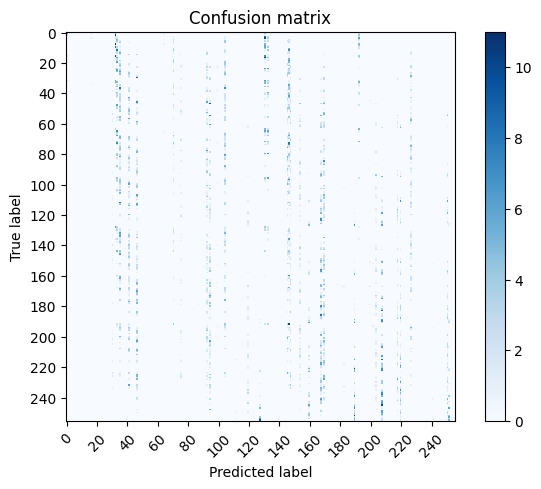

Number of times rank: 0.
Number of times rank: 50.
Number of times rank: 100.
Number of times rank: 150.


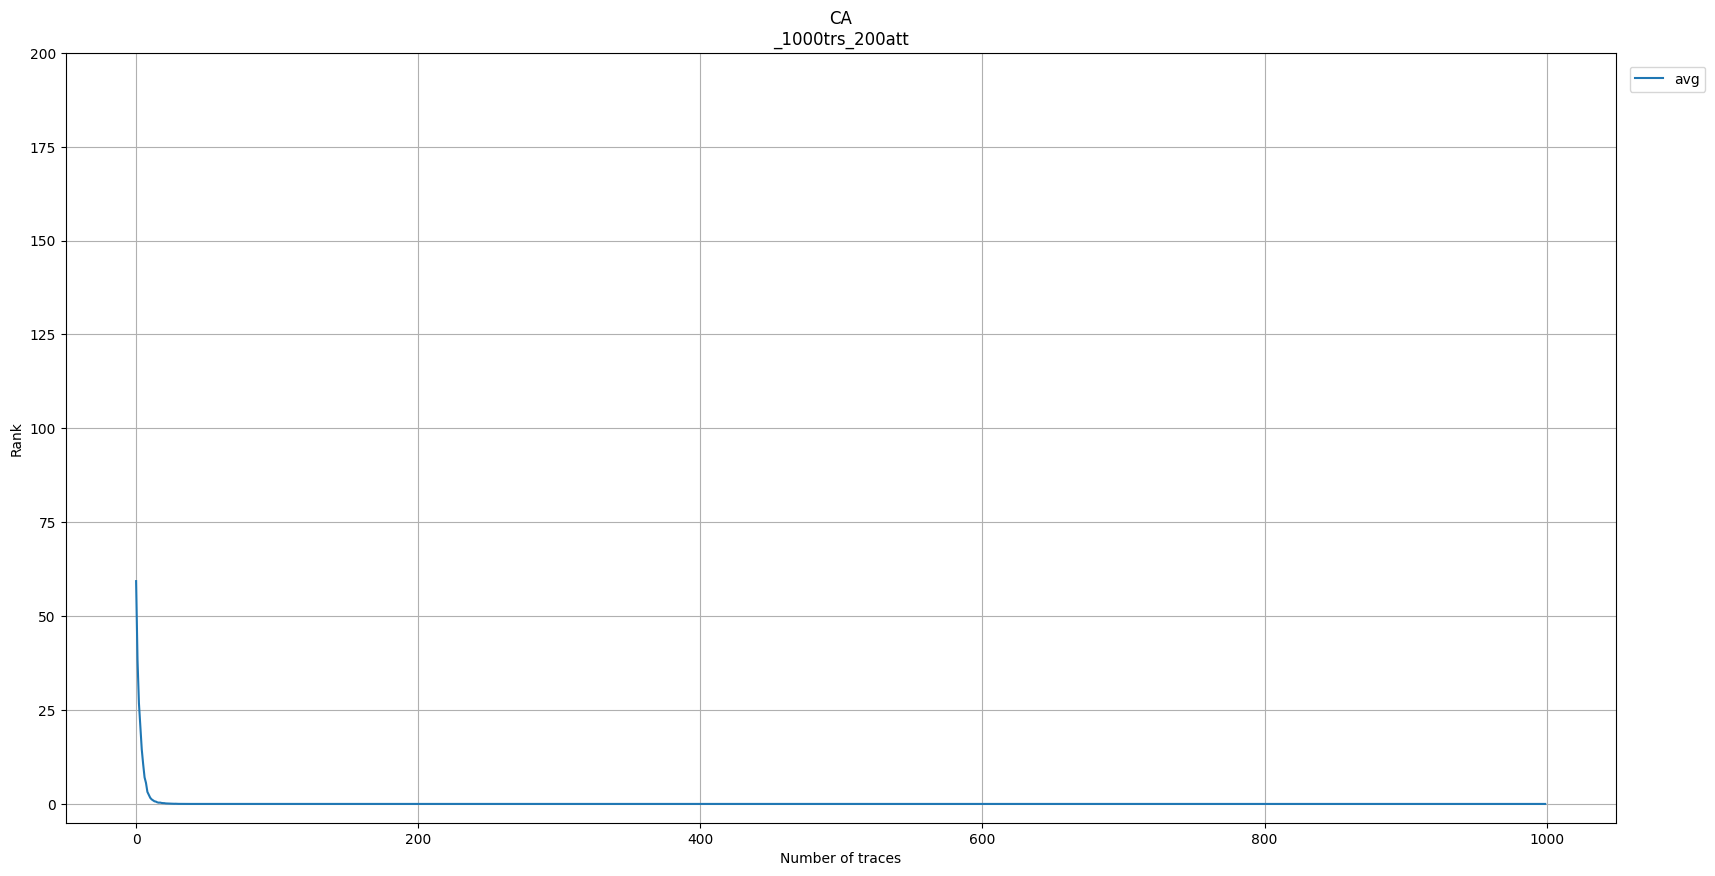

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = './models_CA/CA_model_{}_to_{}.pth'.format(source_device_id, target_device_id)
checkpoint = torch.load(checkpoint_path, map_location='cpu')

CA_model = CA_Net(num_classes=256).to(device)
CA_model.load_state_dict(checkpoint['model_state_dict']) 
CA_model.eval()

print('Results after CA-SCA:')
with torch.no_grad():
    # Uncomment below to evaluate on the source device if desired
#     print('Result on source device:')
#     test_rank(CA_model, source_device_id, model_flag='source')
    print('Result on target device:')
    test_rank(CA_model, target_device_id, model_flag='target')